In [106]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split


from datetime import date, timedelta
import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
import numpy as np # Fundamental package for scientific computing with Python
import joblib
from lib.Measures import measureDataframe2
from lib.Utility import exportExcelWithTimeStamp
import plotly.express as px
from plotly import graph_objects as go
# Train the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

commissioni = 0.0005


In [107]:
tomorrow = date.today() - timedelta(30)

data = yf.download (tickers = "^SPX", start = "1990-09-04",
                              end = tomorrow, interval = "1d").reset_index()
vix = yf.download (tickers = "^VIX", start = "1990-09-04",
                              end = tomorrow, interval = "1d").reset_index()
vvix = yf.download (tickers = "^VVIX", start = "1990-09-04",
                              end = tomorrow, interval = "1d").reset_index()

data['feat_Open'] = data['Open']

vix['feat_vixOpen'] = vix['Open']
vix['feat_vixPrevClose'] = vix['Close'].shift(1)
vvix['feat_vvixOpen'] = vvix['Open']
vvix['feat_vvixPrevClose'] = vvix['Close'].shift(1)
vvix['feat_Acc'] = np.where(vvix['Close'].shift(1) > vvix['Close'].shift(2), 1, 0)

vix = vix.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)
vvix = vvix.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)

data = data.merge(vix, how='left', on='Date')# VIX
data = data.merge(vvix, how='left', on='Date')# vVIX

data['Cluster'] = np.where(data['Close'] > data['Open'], 1, -1)
# data['Cluster'] = np.where(data['Close'] > data['Open']+data['Open']*0.001, 1, np.where(data['Close'] < data['Open']-data['Open']*0.001, -1,0))
data['feat_PrevCluster'] = data['Cluster'].astype('Int64').shift(1)
data['feat_bigBodyRange'] = np.where(abs(data['Close'] - data['Open'])/data['Open'] > 0.01, 1, 0)

data =data.dropna()
# data.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [108]:
# features = [col for col in data.columns if 'feat' in col]
features = ['feat_vvixOpen','feat_vvixPrevClose']
print(features)

x_train, x_test, y_train, y_test = train_test_split(data[features], data['Cluster'], test_size= 0.3, random_state= 2)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train= y_train.sort_index()
y_test = y_test.sort_index()


print (f'X_train: {x_train.shape} \nX_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')

['feat_vvixOpen', 'feat_vvixPrevClose']
X_train: (3070, 2) 
X_test: (1317, 2) 
y_train: (3070,) 
y_test: (1317,)


In [109]:
# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear", random_state=42).fit(x_train, y_train)

# joblib.dump(model, "./LogRegB-Class.joblib")

print (model)

LogisticRegression(C=100.0, random_state=42, solver='liblinear')


In [110]:
df = x_test.copy()

df['predictions'] = model.predict(x_test)
df['y_test'] = y_test

print(f"Accuracy score: {accuracy_score(df['y_test'], df['predictions'])}")

df2 = pd.DataFrame(model.predict_proba(x_test))
df = pd.concat([df, df2])
print(df)
# df.to_excel('pippo.xlsx')


Accuracy score: 0.6203492786636294
      feat_vvixOpen  feat_vvixPrevClose  predictions  y_test         0  \
4121      92.760002           92.040001          1.0    -1.0       NaN   
4122      93.779999           92.760002         -1.0     1.0       NaN   
4129      84.430000           82.489998         -1.0    -1.0       NaN   
4133      81.360001           80.449997          1.0    -1.0       NaN   
4136      77.279999           78.900002          1.0     1.0       NaN   
...             ...                 ...          ...     ...       ...   
1312            NaN                 NaN          NaN     NaN  0.431237   
1313            NaN                 NaN          NaN     NaN  0.521743   
1314            NaN                 NaN          NaN     NaN  0.476927   
1315            NaN                 NaN          NaN     NaN  0.388296   
1316            NaN                 NaN          NaN     NaN  0.458907   

             1  
4121       NaN  
4122       NaN  
4129       NaN  
4133    

C:\Users\vitto\AppData\Local\Temp\ipykernel_22572\2445797263.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Misure per 5.4875 anni
Benchmark Equity: 936.2916259765625
Equity 5060.413206878654
Maximum number of loss operation: 7
Maximum DrawDown: -760.9859282226562
SGR: 922.170971640757 vs Benchmark: 170.6226197679385
Win Rate: 58.618071374335614
Long Equity 3782.4232788085938
Short Equity 2846.1316528320312


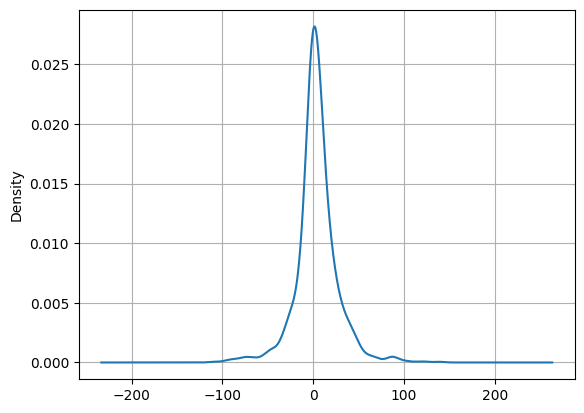

In [111]:

# Seleziona le colonne con il prefisso "feat"
feat_cols = [col for col in data.columns if 'feat' in col]

test_data = data[data.index.isin(x_test.index)]
test_data['cluster'] = model.predict(x_test)

df2 = pd.DataFrame(model.predict_proba(x_test))
df2.index = test_data.index
test_data = test_data.merge(df2, left_index=True, right_index=True)

df_test = pd.DataFrame(test_data)
df_test['color'] = np.where(test_data['cluster']==1,'green','red')

# Calcoliamo la variazione percentuale dei prezzi di chiusura
#df_live['pct_change'] = df_live['Close'].pct_change()
df_test['pct_change'] = (df_test['Close']-df_test['Open'])#/df_live['Open']
df_test['signal'] = np.where(df_test['cluster'] == 1, 1, np.where(df_test['cluster'] == -1, -1, 0))
df_test['commissione'] = commissioni*df_test['Open']
df_test['gain'] = (df_test['cluster']*df_test['pct_change'])-df_test['commissione']
# df_live['gainVolFilter'] = np.where(df_live['bigBodyRangePred'] == 1, (df_live['signal']*df_live['pct_change'])-commissioni, 0)
df_test['longGain'] = np.where(df_test['cluster'] == 1,df_test['cluster']*df_test['pct_change'], 0)
df_test['shortGain'] = np.where(df_test['cluster'] == -1, df_test['cluster']*df_test['pct_change'], 0)  
df_test['equity'] = np.cumsum(df_test['gain'])
# df_live['equityVolatilityFilter'] = np.cumsum(df_live['gainVolFilter'])

measureDataframe2(df_test)
exportExcelWithTimeStamp(df_test, "Equity/", "TestEquity.xlsx")

fig = go.Figure(data=[go.Candlestick(x=test_data['Date'],
                open=test_data['Open'],
                close=test_data['Close'], high=test_data['High'], low=test_data['Low'], opacity=0.5)])
sec_y = go.layout.YAxis(title='Equity')#, offset=dict(type="absolute", value=0.25))
fig.add_trace(go.Scatter(x=df_test['Date'], y=df_test['equity'], name='Equity', line=dict(color='blue')) )
fig.add_scatter(x=test_data['Date'], y=test_data['Open'], mode='markers',marker=dict(color=df_test['color']))
# fig.add_trace(go.Line(x=df['Date'], y=df['equity'], name='Equity'))
# fig.add_trace(go.Scatter(x=df_live['Date'], y=df_live['equityVolatilityFilter'], name='Equity Volatility Filter'))




fig.update_layout(
    xaxis_rangeslider_visible=False,
                  yaxis2=dict(
        title='Equity',
        overlaying='y',  # Sovrappone il secondo asse y al primo
        side='right',  # Posiziona il secondo asse y a destra
        showgrid=False  # Nasconde la griglia per il secondo asse y se necessario
    ))
# Associa la serie Equity al secondo asse y
fig.data[1].update(yaxis='y2')
fig.show()

# Plot distribution of values in Marks column
df_test['gain'].plot(kind='kde')
plt.grid()

## LIVE

In [112]:
before = date.today() - timedelta(300)
tomorrow = date.today() + timedelta(1)

dataLive = yf.download (tickers = "^SPX", start = before,
                              end = tomorrow, interval = "1d").reset_index()
vixLive = yf.download (tickers = "^VIX", start = before,
                              end = tomorrow, interval = "1d").reset_index()
vvixLive = yf.download (tickers = "^VVIX", start = before,
                              end = tomorrow, interval = "1d").reset_index()

vixLive['feat_vixOpen'] = vixLive['Open']
vixLive['feat_vixPrevClose'] = vixLive['Close'].shift(1)
vvixLive['feat_vvixOpen'] = vvixLive['Open']
vvixLive['feat_vvixPrevClose'] = vvixLive['Close'].shift(1)
#data['feat_VolChange'] = (data['Volume'].shift(1) - data['Volume'].shift(2)) / data['Volume'].shift(2)
# data['feat_prevClose'] = data['Close'].shift(1)
# data['bigBodyRange'] = np.where(abs(data['Close'] - data['Open'])/data['Open'] > 0.004, 1, 0)
vvixLive['feat_Acc'] = np.where(vvixLive['Close'].shift(1) > vvixLive['Close'].shift(2), 1, 0)
vixLive = vixLive.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)
vvixLive = vvixLive.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)

dataLive['feat_Open'] = dataLive['Open']
dataLive = dataLive.merge(vixLive, how='left', on='Date')# VIX
dataLive = dataLive.merge(vvixLive, how='left', on='Date')# vVIX

dataLive['Cluster'] = np.where(dataLive['Close'] > dataLive['Open'], 1, -1)
# dataLive['Cluster'] = np.where(dataLive['Close'] > dataLive['Open']+dataLive['Open']*0.001, 1, np.where(dataLive['Close'] < dataLive['Open']-dataLive['Open']*0.001, -1,0))
dataLive['feat_PrevCluster'] = dataLive['Cluster'].astype('Int64').shift(1)
dataLive['feat_bigBodyRange'] = np.where(abs(dataLive['Close'] - dataLive['Open'])/dataLive['Open'] > 0.01, 1, 0)



dataLive =dataLive.dropna()
# dataLive.head(15)
vvixLive.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,feat_vvixOpen,feat_vvixPrevClose,feat_Acc
200,2024-07-17,85.379997,82.400002,0
201,2024-07-18,85.989998,88.279999,1
202,2024-07-19,94.879997,94.709999,1
203,2024-07-22,97.519997,97.930000,1
204,2024-07-23,93.540001,93.660004,0


In [113]:
# CLASSIFICATION
clf = loaded_rf = joblib.load("./LogRegB-Class.joblib")

# Seleziona le colonne con il prefisso "feat"
# features = [col for col in data.columns if 'feat' in col]
features = ['feat_vvixOpen','feat_vvixPrevClose']
print(features)

x_live = dataLive[features]

y_live_pred = clf.predict(x_live)
dataLive['cluster'] = y_live_pred

print(f"Accuracy score: {accuracy_score(dataLive['Cluster'], dataLive['cluster'])}")

df_live = pd.DataFrame(dataLive)
# dataLive['signal'] = np.where(dataLive['cluster'] == 1, 1, np.where(dataLive['cluster'] == 0, -1, 0)) 
dataLive['color'] = np.where(dataLive['cluster']==1,'green','red')


# Calcoliamo la variazione percentuale dei prezzi di chiusura
#df_live['pct_change'] = df_live['Close'].pct_change()
df_live['pct_change'] = (df_live['Close']-df_live['Open'])#/df_live['Open']
# df_live['signal'] = np.where(df_live['cluster'] == 1, 1, np.where(df_live['cluster'] == -1, -1, 0)) 
df_live['commissione'] = abs(df_live['cluster'])*commissioni*df_live['Open']
df_live['gain'] = (df_live['cluster']*df_live['pct_change'])-df_live['commissione']
# df_live['gainVolFilter'] = np.where(df_live['bigBodyRangePred'] == 1, (df_live['signal']*df_live['pct_change'])-commissioni, 0)
df_live['longGain'] = np.where(df_live['cluster'] == 1, (df_live['cluster']*df_live['pct_change']), 0)
df_live['shortGain'] = np.where(df_live['cluster'] == -1, (df_live['cluster']*df_live['pct_change']), 0)  
df_live['equity'] = np.cumsum(df_live['gain'])
# df_live['equityVolatilityFilter'] = np.cumsum(df_live['gainVolFilter'])


measureDataframe2(df_live)

exportExcelWithTimeStamp(df_live, "Equity/", "LiveEquity.xlsx")

# LIVE

fig = go.Figure(data=[go.Candlestick(x=df_live['Date'],
                open=df_live['Open'],
                close=df_live['Close'], high=df_live['High'], low=df_live['Low'], opacity=0.5)])
# sec_y = go.layout.YAxis(title='Equity')#, offset=dict(type="absolute", value=0.25))

# fig.add_trace(go.Line(x=df_live['Date'], y=df_live['equity'], name='Equity'))
fig.add_trace(go.Scatter(x=df_live['Date'], y=df_live['equity'], name='Equity', line=dict(color='blue')) )
fig.add_scatter(x=df_live['Date'], y=df_live['Open'], mode='markers',marker=dict(color=dataLive['color']))

fig.update_layout(
    xaxis_rangeslider_visible=False,
                  yaxis2=dict(
        title='Equity',
        overlaying='y',  # Sovrappone il secondo asse y al primo
        side='right',  # Posiziona il secondo asse y a destra
        showgrid=False  # Nasconde la griglia per il secondo asse y se necessario
    ))
# Associa la serie Equity al secondo asse y
fig.data[1].update(yaxis='y2')
fig.show()

['feat_vvixOpen', 'feat_vvixPrevClose']
Accuracy score: 0.5588235294117647
Misure per 0.85 anni
Benchmark Equity: 569.58154296875
Equity -392.34703784179663
Maximum number of loss operation: 5
Maximum DrawDown: -414.7637629394529
SGR: -461.5847504021137 vs Benchmark: 670.0959329044118
Win Rate: 50.0
Long Equity 340.921875
Short Equity -228.65966796875
